# Homework 2

Devote more effort in discussing your results based on the concepts covered in class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

## Task 2

Implement the extension of the Barabasi-Albert model with fitness. Define a function
barabasi_albert_fitness(N, m, m0, fitness_scores, nodes_monitor, seed), where:

- N: the final number of nodes in the generated network (ensure node i corresponds to the i-th added
node to the network),

- m is the number of links that every new node adds and m0 the size of the initial clique,

- fitness_scores: list of fitness values for each node such that fitness_scores[i] is the fitness of
the i-th introduced node (for the first m0 nodes, assign their fitness as you like among the elements
of fitness_scores[ :m0]),

- nodes_monitor: list of nodes to monitor,

- seed: random seed for reproducibility.

The function has to return the generated graph (G) and the evolution history of the nodes in nodes_monitor
(G_hist). The evolution history has to track, for each step, the node ID, node fitness, step at which the
node was introduced, the current step, and its degree at the current step.

In [2]:
def barabasi_albert_model(N, m, m0=5, fitness_scores=[], seed=None, nodes_monitor=None):
    if seed is None:
        RNG = np.random.RandomState()
    elif type(seed) is int:
        RNG = np.random.RandomState(seed)
    elif type(seed) is np.random.RandomState:
        RNG = seed
    else:
        raise ValueError("Unknown seed type")
    
    if fitness_scores is None:
        fitness_scores = np.ones(N)

    #Initialize history
    G_hist = {}
    if nodes_monitor:
        for node in nodes_monitor:
            G_hist[node] = {
                'id': node,
                'fitness': fitness_scores[node],
                'introduction_step': None,
                'steps': []
            }

    #Add the initial nodes
    G = nx.complete_graph(m0)
    for i in range(m0):
        G.nodes[i]['fitness'] = fitness_scores[i]
        if i in nodes_monitor:
            G_hist[i]['introduction_step'] = 0
            G_hist[i]['steps'].append(
                {
                    'step': 0,
                    'degree': m0 - 1,
                }
            )

    #Add the remaining N - m0 nodes
    for i in range(m0, N):
        degrees = np.array([G.degree(n) for n in G.nodes])
        fitnesses = np.array([G.nodes[n]['fitness'] for n in G.nodes])
        weights = degrees * fitnesses
        probs = weights / weights.sum()

        #select m nodes to connect to
        targets = RNG.choice(G.nodes, size=m, replace=False, p=probs)

        G.add_node(i)
        G.add_edges_from((i, t) for t in targets)

        G.nodes[i]['fitness'] = fitness_scores[i]
        if i in nodes_monitor:
            G_hist[i]['introduction_step'] = i
            
        for node in nodes_monitor:
            G_hist[node]['steps'].append(
                {
                    'step': i-m0+1,
                    'degree': 0 if node not in G.nodes else G.degree(node)
                }
            )

    if nodes_monitor is None:
        return G
    
    return G, G_hist

**Consider nodes_monitor = [100, 101, 102, 103, 104, 105, 200, 201, 202, 203, 204, 205] and
node fitness to be uniformly distributed in the interval [0, 1]. Before running the code, how would you expect the degree of the monitored nodes to grow as a function of time? Would you expect their evolution
to differ from the one in the vanilla BA model? Reply to this question before running the experiment.**

In the BA-model, the earlier a node is introduced to the network, the higher its degree is expected to be. Early introduced nodes had "more time to grow" and since newly added nodes have lower degrees, preferential attachment will result in an even higher bias towards the early nodes.

Since we consider 6-6 nodes, with a difference of 100 steps in introduction, nodes 100-105 are on average expected to have higher degrees than nodes 200-205 at the end of the simulation.

With the fitness model, we can expect that the nodes with higher fitness can overtake lower fitness nodes even if their degree is smaller (if the fitness weighted probability do not differ too much). We can see below the fitness scores of the nodes, we expect to see that high fitness nodes such as node 200 and 202 will have much greater degree "development" than in the vanilla BA model. Similarly, low fitness nodes such as node 100 and 103 will have lower degree "development" than in the vanilla BA model.

In [3]:
fitness_scores = np.loadtxt(r'.\datasets\fitness_scores_baf.txt')
fitness_scores[100:106], fitness_scores[200:206]

(array([0.3266449 , 0.5270581 , 0.8859421 , 0.35726976, 0.90853515,
        0.62336012]),
 array([0.95017612, 0.55665319, 0.91560635, 0.64156621, 0.39000771,
        0.48599067]))

Now test your hypothesis by running a simulation. Follow the steps below:

- (a) Set N=2000, m=5, and m0=5. Load the fitness_scores list for the BA-fitness model from the pro-
vided file (np.loadtxt(file_path)). The values have been generated from a uniform distribution
in [0, 1].

- (b) Generate two graphs: one from the BA model and another from the BA-fitness model. For the BA
model, use the same barabasi_albert_fitness function by defining an appropriate list of fitness.

- (c) Repeat step (b) 50 times and concatenate all the evolution histories. Use the same fitness_scores
list in all iterations.

- (d) Plot the average degree of each node as a function of time for the two models.
(hint: define a variable rel_t = t - t_creation for each node)

Do the results of the simulation support your initial hypothesis? You are free to visualize the results as
you prefer. Just make sure that the visualization effectively reflects your discussion.

Points: 3 points for the implementation, 3 points for the preliminary hypotheses, 3 points for the
analysis of the results (total: 9 points)

In [4]:
N=2000
m=5
m0=5
nodes_monitor = [100, 101, 102, 103, 104, 105, 200, 201, 202, 203, 204, 205]

In [5]:
def BA_models_results(N, m, m0, fitness_scores, nodes_monitor):
    G_ba, G_hist_ba = barabasi_albert_model(N, m, m0,  [1]*N, nodes_monitor=nodes_monitor)
    G_baf, G_hist_baf = barabasi_albert_model(N, m, m0, fitness_scores, nodes_monitor=nodes_monitor)
    return G_ba, G_hist_ba, G_baf, G_hist_baf

def BA_models_results_iterated(N, m, m0, fitness_scores, nodes_monitor, i):
    G_hists_ba = []
    G_hists_baf = []
    for _ in range(i):
        G_ba, G_hist_ba, G_baf, G_hist_baf = BA_models_results(N, m, m0, fitness_scores, nodes_monitor)
        G_hists_ba.append(G_hist_ba)
        G_hists_baf.append(G_hist_baf)
    return G_hists_ba, G_hists_baf

def hists_node_avg_degree(histories, node):
    degrees_per_step = {j:[h[node]['steps'][j]['degree'] for h in histories] for j in range(2000-5)}
    return {j:np.mean(degrees_per_step[j]) for j in degrees_per_step}
    
def hists_nodes_avg_degree(histories, nodes):
    return {node:hists_node_avg_degree(histories, node) for node in nodes}

def BA_models_nodes_degree_evaluation(G_hists_ba, G_hists_baf):
    nodes = [node for node in G_hists_ba[0]] #assuming all histories have the same nodes, for both models
    nodes_creation = {node:G_hists_ba[0][node]['introduction_step'] for node in nodes}
    nodes_avg_degree_ba = hists_nodes_avg_degree(G_hists_ba, nodes)
    nodes_avg_degree_baf = hists_nodes_avg_degree(G_hists_baf, nodes)

    plt.figure(figsize=(15, 12))

    for i, node in enumerate(nodes):
        node_creation = nodes_creation[node]
        reindexed_steps = [t-node_creation for t in list(nodes_avg_degree_ba[node].keys())]
        plt.subplot(3, 4, i+1)
        plt.plot(reindexed_steps, list(nodes_avg_degree_ba[node].values()), label='BA model', color='blue')
        plt.plot(reindexed_steps, list(nodes_avg_degree_baf[node].values()), label='Fitness BA model', color='red')
        plt.xlim(0, 2000-node_creation)
        plt.title(f'Node {node}')
        plt.xlabel('Step (relative to creation)')
        plt.ylabel('Average degree')
        plt.legend()

    plt.tight_layout()
    plt.show()
    return nodes_avg_degree_ba, nodes_avg_degree_baf, nodes

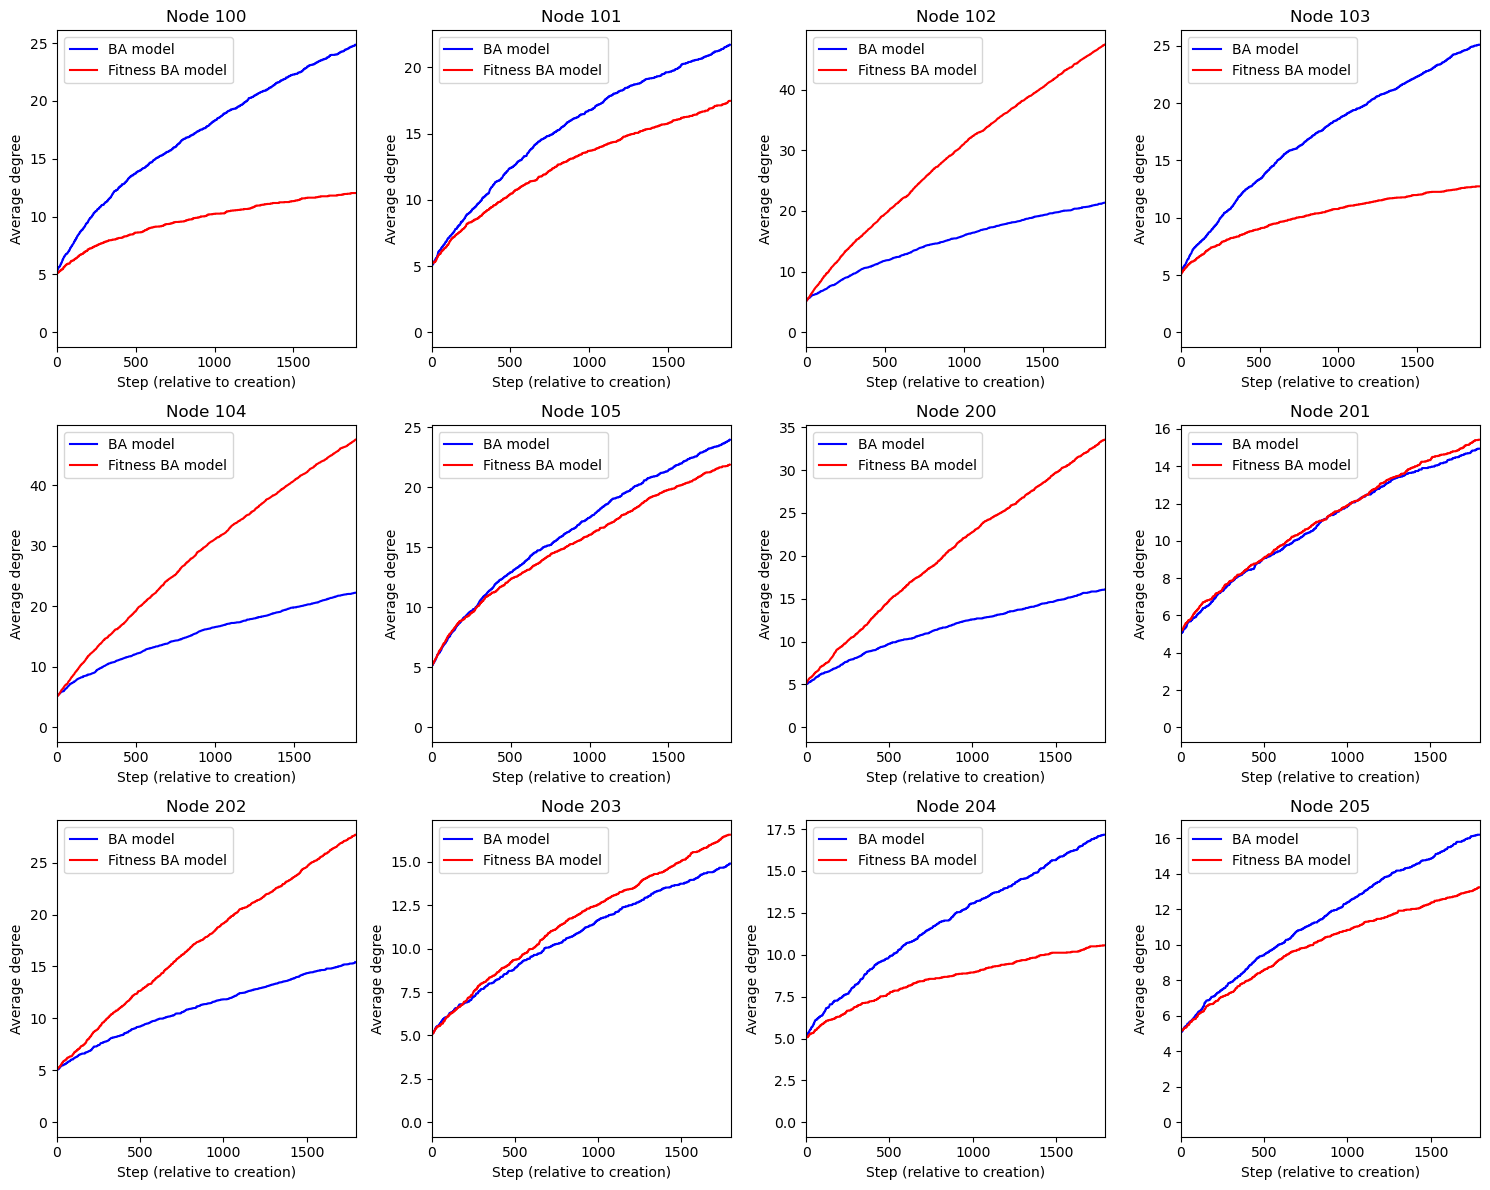

In [6]:
G_hists_ba, G_hists_baf = BA_models_results_iterated(N, m, m0, fitness_scores, nodes_monitor, 50)
nodes_avg_degree_ba, nodes_avg_degree_baf, nodes = BA_models_nodes_degree_evaluation(G_hists_ba, G_hists_baf)

We mentioned two nodes with high fitness in the second "chunk" (200-205), and two nodes with low fitness in the first "chunk" (100-105). Indeed, for both 200 and 202, the degree development is much higher in the fitness model than in the vanilla BA model, up to 2-3 times higher after <2000 steps.<br>For 100 and 103, the degree development is much lower in the fitness model than in the vanilla model.

The diagram also confirms our hypothesis that the second chunk has lower average degree than the first chunk in the vanilla BA model.

While the fitness model does lower the bias towards early nodes, we can see that that bias is still somewhat present. Node 104 was added in the 100th iteration, and has ~0.9085 fitness, and alongside node 102 which has ~0.8860 fitness these have the highest average degree among the observed nodes. In comparison, node 200 which was added less than 100 steps later, has ~0.9502 fitness, yet has 30% less nodes after <2000 iterations. The high degree of earlier two nodes outweighs the higher fitness of the later node, and these nodes will continue to gather more links than later nodes.

Extra thought: One missing component of both models is some "fixed point attractors" behaviour. If a node with high fitness also gradually builds a high degree, it will dominate the same way . In essence, the rules for network development in a step is the same as the BA model, the only difference is that we use a fitness*degree as probability to update a degree - this reduces temporal bias for node "success to grow to be a hub" but the game is the same, the higher this value, the higher chance that the hub grows bigger, in each step. This results in rich-get-richer phenomena, with order of magnitude differences. In some systems, there is not so big discrepancy between entities, and the biggest hubs cannot keep growing so disproportionately - new nodes cannot benefit the biggest hubs so often, and the "market" seems to grow more balanced. This is what I mean by fixed point attractors, the BA models grow away from a proportional state with increasing "speed" (higher probabilities increase degree, increasing the probabilities, these are positive feedback loops and the system is ought to blow up), opposite to behaviour when the system does not accelerate away from a balanced state.